# Name: Gengcong Yan
# Student Number: 1009903

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import silhouette_score,davies_bouldin_score,normalized_mutual_info_score
from sklearn.cluster import KMeans, SpectralClustering

# Task 4

In [2]:
def Compute_indexs_KM(data,ground,min,max):
    print("Kmeans")
    indexs=[]
    for numc in range(min,max+1):

        KM = KMeans(n_clusters=numc)
        predicted_labels=KM.fit_predict(data)
        # print("Predicted_labels:\n",predicted_labels)

        silhouette_avg = silhouette_score(data, predicted_labels)
        dh=davies_bouldin_score(data, predicted_labels)
        
        label_true=ground.to_numpy().reshape(1,-1)[0]
        nmi=normalized_mutual_info_score(label_true,predicted_labels)
        indexs.append([silhouette_avg,dh,nmi])
        # print("For n_clusters={}, SI={},DB={},NMI={}".format(numc,round(silhouette_avg,3),round(dh,3),round(nmi,3)))
    
    return np.round(pd.DataFrame(indexs,columns=["SI","DB","NMI"]),3)

def Compute_indexs_SC(data,ground,min,max,method):
    print("Spectral Cluster with "+method)
    indexs=[]
    for numc in range(min,max+1):

        SC= SpectralClustering(n_clusters=numc,affinity=method)
        predicted_labels=SC.fit_predict(data)
        # print("Predicted_labels:\n",predicted_labels)

        silhouette_avg = silhouette_score(data, predicted_labels)
        dh=davies_bouldin_score(data, predicted_labels)
        
        label_true=ground.to_numpy().reshape(1,-1)[0]
        nmi=normalized_mutual_info_score(label_true,predicted_labels)
        indexs.append([silhouette_avg,dh,nmi])
        # print("For n_clusters={}, SI={},DB={},NMI={}".format(numc,round(silhouette_avg,3),round(dh,3),round(nmi,3)))
    
    return np.round(pd.DataFrame(indexs,columns=["SI","DB","NMI"]),3)

# Data: spirals.txt

In [3]:
# prepare data

sprialsdata = pd.read_csv('spirals.txt', sep=",", header=None)
sprialsdata.columns = ["X", "Y", "Class", ]
sprialsdata=sprialsdata[1:].astype("float64")

sprialsdata_train=sprialsdata[["X","Y"]]
sprialsdata_ground=sprialsdata[["Class"]]

print(sprialsdata_train.head())

print(sprialsdata_ground.head())


       X     Y
1  31.95  7.95
2  31.15  7.30
3  30.45  6.65
4  29.70  6.00
5  28.90  5.55
   Class
1    3.0
2    3.0
3    3.0
4    3.0
5    3.0


In [4]:
KM=Compute_indexs_KM(sprialsdata_train, sprialsdata_ground,2,5)
print(KM)

SC_With_Laplacian=Compute_indexs_SC(sprialsdata_train, sprialsdata_ground,2,5,method="laplacian")
print(SC_With_Laplacian)

SC_With_RBF=Compute_indexs_SC(sprialsdata_train, sprialsdata_ground,2,5,method="rbf")
print(SC_With_RBF)

Kmeans
      SI     DB    NMI
0  0.348  1.168  0.001
1  0.361  0.887  0.001
2  0.354  0.879  0.002
3  0.344  0.888  0.005
Spectral Cluster with laplacian
      SI     DB    NMI
0  0.345  1.173  0.000
1  0.362  0.896  0.002
2  0.330  0.928  0.052
3  0.279  1.818  0.134
Spectral Cluster with rbf
      SI     DB    NMI
0  0.052  5.469  0.340
1  0.001  5.882  1.000
2 -0.012  6.914  0.910
3  0.015  5.459  0.833


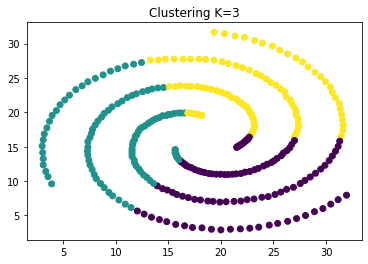

In [5]:
KM = KMeans(n_clusters=3)
predicted_labels=KM.fit_predict(sprialsdata_train)

# SC= SpectralClustering(n_clusters=3,affinity="laplacian")
# predicted_labels=SC.fit_predict(sprialsdata_train)

# SC= SpectralClustering(n_clusters=3,affinity="rbf")
# predicted_labels=SC.fit_predict(sprialsdata_train)

plt.title("Clustering K=3")
plt.scatter(sprialsdata_train[["X"]], sprialsdata_train[["Y"]], c=predicted_labels)

# Task 4   new index tau

In [6]:
def Gauss_sim_2d(P1,P2,gamma=1.0):
    dis=np.linalg.norm(P1-P2)
    return np.exp(-gamma * dis ** 2)


def new_validation_index(data,pred_labels):
    new_data=data.to_numpy().astype("float64")
    lens=len(new_data)
    T=0
    for i in range(lens):
        a,b=0,0
        for j in range(lens):
            if j!=i:
                sim=Gauss_sim_2d(new_data[i],new_data[j])  
                a+=(pred_labels[i]==pred_labels[j])*sim
                b+=sim
        T+=a/b
    T=T/lens
    return T

def indexs_using_neighbour(data,pred_labels,n_nghbours=20):

    kg=kneighbors_graph(sprialsdata_train,n_neighbors=n_nghbours)

    new_data=data.to_numpy().astype("float64")
    lens=len(new_data)
    T=0
    for i in range(lens):
        a,b=0,0
        for j in range(lens):
            if j!=i:
                sim=Gauss_sim_2d(new_data[i],new_data[j])  
                a+= kg[i,j] *(pred_labels[i]==pred_labels[j])*sim
                b+=kg[i,j] * sim
        T+=a/b
    T=T/lens
    return T
    
    

In [7]:
res=[]
for numc in range(2,6):

    SC= SpectralClustering(n_clusters=numc,affinity="rbf")
    predicted_labels=SC.fit_predict(sprialsdata_train)

    t=new_validation_index(sprialsdata_train,predicted_labels)
    res.append( round(t,4) )

res

[1.0, 1.0, 0.9965, 0.9921]

In [8]:
res=[]
for numc in range(2,6):

    SC= SpectralClustering(n_clusters=numc,affinity="laplacian")
    predicted_labels=SC.fit_predict(sprialsdata_train)

    t=new_validation_index(sprialsdata_train,predicted_labels)
    res.append( round(t,4) )

res

[0.9782, 0.975, 0.9701, 0.9592]

In [36]:
res=[]
for numc in range(2,6):

    KM = KMeans(n_clusters=numc)
    predicted_labels=KM.fit_predict(sprialsdata_train)

    t=new_validation_index(sprialsdata_train,predicted_labels)
    res.append(round(t,4))

res

[0.9725, 0.9434, 0.9492, 0.9418]

In [9]:
res=[]
for numc in range(2,6):

    KM = KMeans(n_clusters=numc)
    predicted_labels=KM.fit_predict(sprialsdata_train)

    t=indexs_using_neighbour(sprialsdata_train,predicted_labels,5)
    res.append(round(t,4))

res

# n=20 [0.9718, 0.9487, 0.9509, 0.9427] kmeans
# n=10 [0.9726, 0.9484, 0.9493, 0.942]  kmeans
# n=5  [0.9733, 0.9617, 0.9555, 0.9453] kmeans

# n=20 [1.0, 1.0, 0.9965, 0.9921] sc-rbf
# n=10 [0.9895, 1.0, 0.9965, 0.9921] sc-rbf
# n=5  1.0, 1.0, 0.9965, 0.9923  sc-rbf

In [ ]:
res=[]
for numc in range(2,6):

    SC= SpectralClustering(n_clusters=numc,affinity="rbf")
    predicted_labels=SC.fit_predict(sprialsdata_train)

    t=indexs_using_neighbour(sprialsdata_train,predicted_labels,5)
    res.append( round(t,4) )

res

[1.0, 1.0, 0.9965, 0.9923]

In [5]:
kg=kneighbors_graph(sprialsdata_train,3)